In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,InputLayer
from tensorflow.keras.regularizers import l2  
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

C:\Users\bhaga\AppData\Local\Temp\ipykernel_15464\3361433389.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
data_path = "KAGGLE/DATASET-balanced.csv"
data = pd.read_csv(data_path)

In [4]:
data.sample(5)

,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,LABEL
4436,0.484856,0.013806,3949.265587,3721.641769,6966.675793,0.119460,-447.611328,104.502769,-21.141325,33.468342,...,0.888552,-9.800359,-6.332394,-8.438732,-5.667273,-8.954735,-3.105276,-5.203973,-4.205182,FAKE
5086,0.360994,0.035078,2176.444792,2503.407771,3675.731489,0.064811,-336.523804,137.420364,-31.982708,-13.268907,...,4.366296,2.432202,-6.014542,-1.617661,2.606310,-3.679496,-1.794911,-4.738746,-4.009971,FAKE
4231,0.496467,0.009649,3602.544285,3706.438567,6396.854961,0.107806,-511.143738,112.541817,-16.892298,35.080547,...,-3.400408,2.310266,5.593368,-4.093721,1.050437,-0.449007,-1.379351,0.760051,-0.145145,FAKE
8370,0.329543,0.054252,1842.364570,2165.055060,2927.318816,0.045044,-325.049439,181.944000,-51.541836,-1.918560,...,-7.346897,2.463671,-4.271305,-8.470842,-1.991832,-12.330347,-11.882207,0.368483,-5.738751,REAL
5066,0.464983,0.005451,4248.260268,4044.481010,7659.721313,0.141638,-522.527527,116.096619,-11.765450,21.276348,...,-10.875139,6.177423,-1.715257,-6.446085,7.907304,-4.875443,-2.778035,5.333901,-4.868314,FAKE


-----------------------EDA----------------------

In [5]:
real_audio = "DEMONSTRATION/DEMONSTRATION/linus-original-DEMO.mp3"
fake_audio = "DEMONSTRATION/DEMONSTRATION/linus-to-musk-DEMO.mp3"

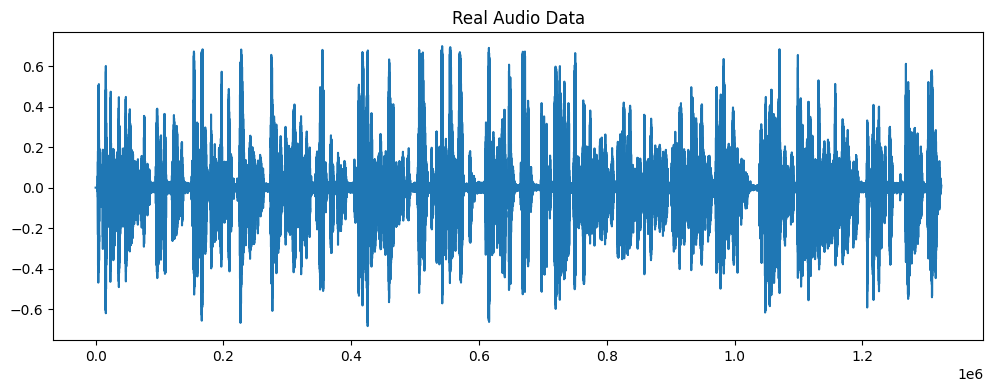

In [6]:
real_ad, real_sr = librosa.load(real_audio)
plt.figure(figsize=(12, 4))
plt.plot(real_ad)
plt.title("Real Audio Data")
plt.show()


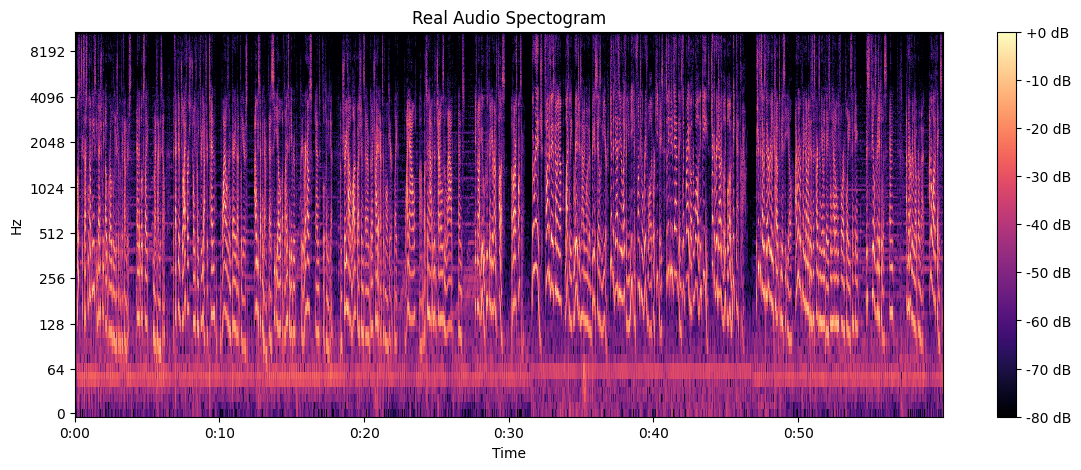

In [7]:
real_spec = np.abs(librosa.stft(real_ad))
real_spec = librosa.amplitude_to_db(real_spec, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_spec, sr=real_sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Real Audio Spectogram")
plt.show()

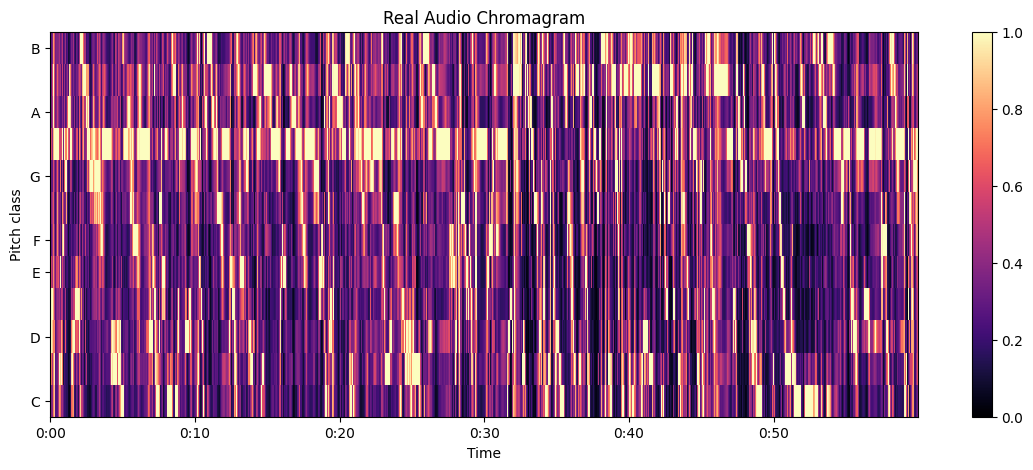

In [8]:
real_chroma = librosa.feature.chroma_cqt(y=real_ad, sr=real_sr, bins_per_octave=36)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_chroma, sr=real_sr, x_axis="time", y_axis="chroma", vmin=0, vmax=1)
plt.colorbar()
plt.title("Real Audio Chromagram")
plt.show()


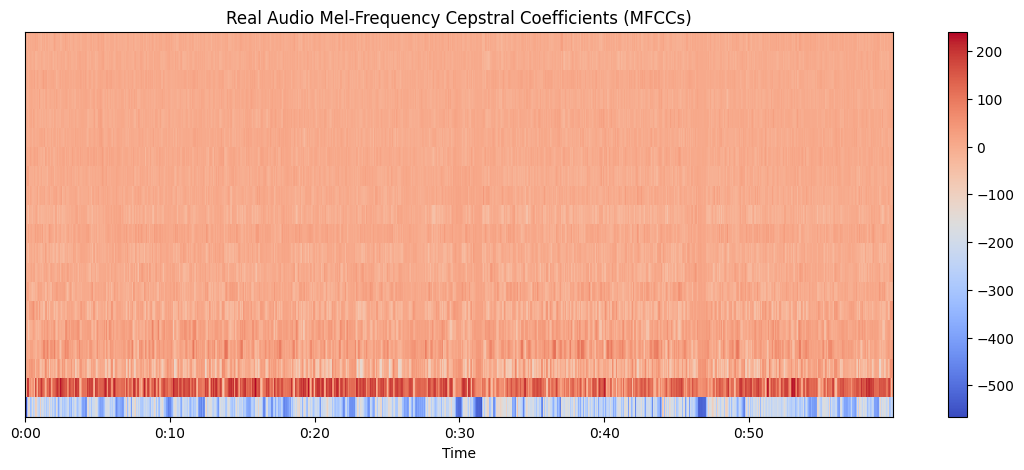

In [9]:
real_mfccs = librosa.feature.mfcc(y=real_ad, sr=real_sr)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_mfccs, sr=real_sr, x_axis="time")
plt.colorbar()
plt.title("Real Audio Mel-Frequency Cepstral Coefficients (MFCCs)")
plt.show()


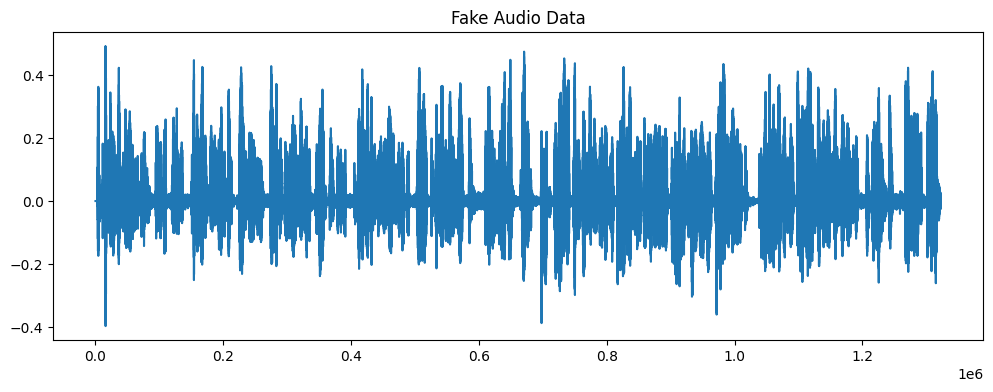

In [10]:
fake_ad, fake_sr = librosa.load(fake_audio)
plt.figure(figsize=(12, 4))
plt.plot(fake_ad)
plt.title("Fake Audio Data")
plt.show()

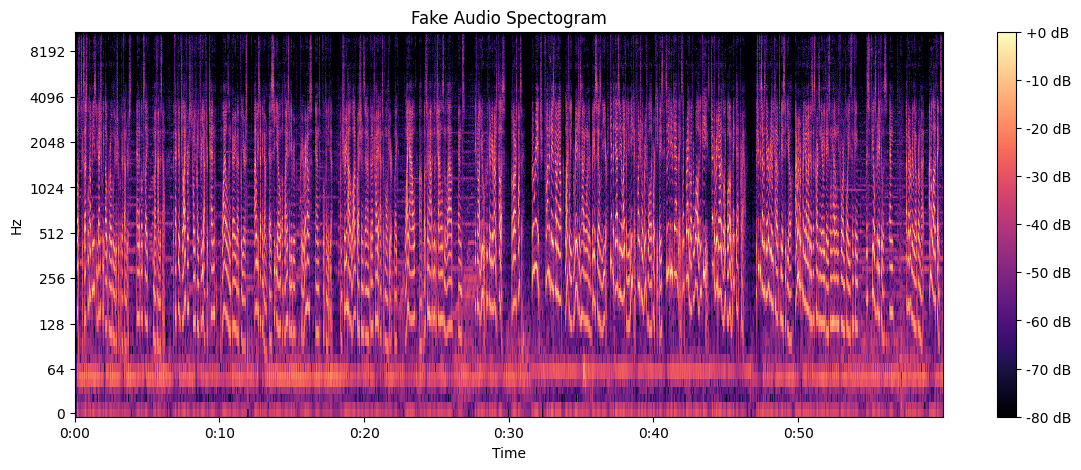

In [11]:
fake_spec = np.abs(librosa.stft(fake_ad))
fake_spec = librosa.amplitude_to_db(fake_spec, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_spec, sr=fake_sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Fake Audio Spectogram")
plt.show()

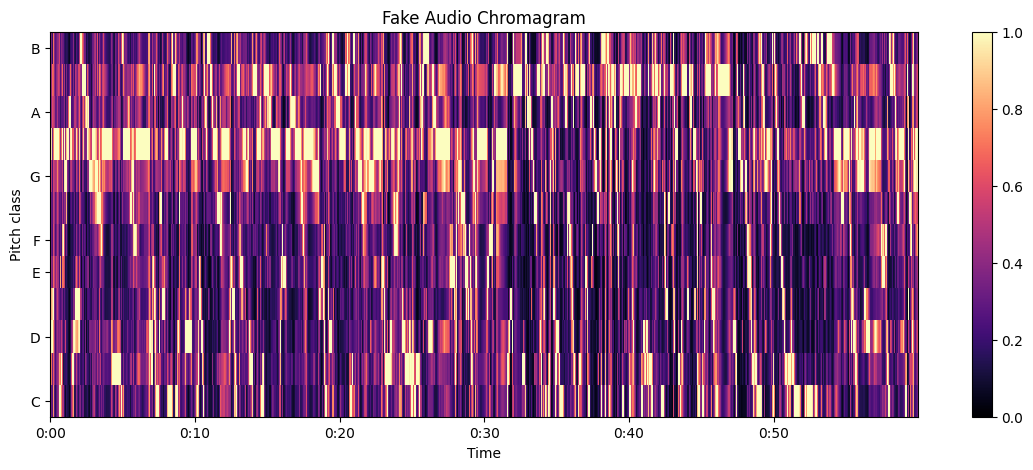

In [12]:
fake_chroma = librosa.feature.chroma_cqt(y=fake_ad, sr=fake_sr, bins_per_octave=36)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_chroma, sr=fake_sr, x_axis="time", y_axis="chroma", vmin=0, vmax=1)
plt.colorbar()
plt.title("Fake Audio Chromagram")
plt.show()

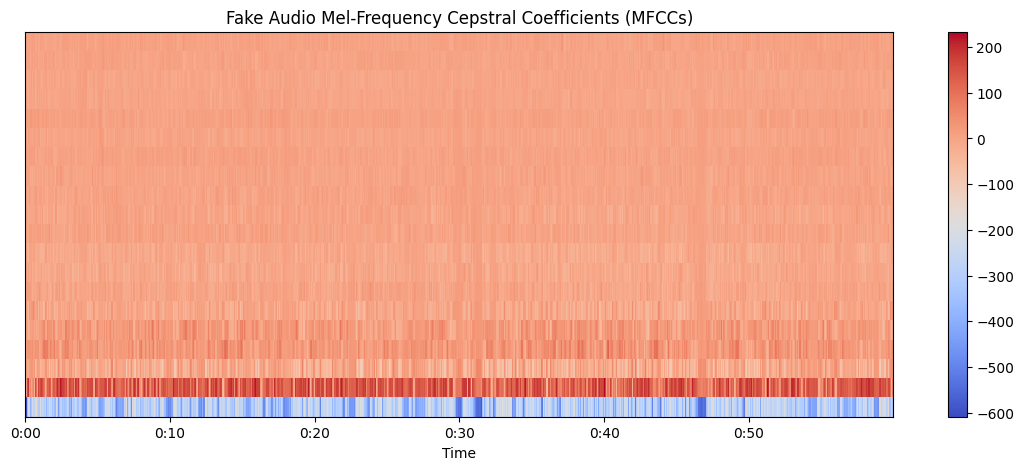

In [13]:
fake_mfccs = librosa.feature.mfcc(y=fake_ad, sr=fake_sr)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_mfccs, sr=fake_sr, x_axis="time")
plt.colorbar()
plt.title("Fake Audio Mel-Frequency Cepstral Coefficients (MFCCs)")
plt.show()

PRE-PROCESSING

In [14]:
X = data.drop('LABEL', axis=1).values  
y = data['LABEL'].values               

label_encoder = preprocessing.LabelEncoder() 
y = label_encoder.fit_transform(y)  # Converts 'real'/'fake' to 0/1

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X).reshape(-1, 1, 26, 1)

In [15]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"Training data shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Test data shape: X_test: {X_test.shape}, y_test: {y_test.shape}")

Training data shape: X_train: (9422, 1, 26, 1), y_train: (9422,)
Test data shape: X_test: (2356, 1, 26, 1), y_test: (2356,)


In [16]:
pd.value_counts(data['LABEL'])

C:\Users\bhaga\AppData\Local\Temp\ipykernel_15464\256854126.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(data['LABEL'])


LABEL
FAKE    5889
REAL    5889
Name: count, dtype: int64

In [20]:
# Build the CNN Model with L2 Regularization and Increased Dropout
def build_cnn_model(input_shape):
    model = Sequential()

    # Input layer to specify input shape
    model.add(InputLayer(input_shape=input_shape))

    # CNN layers for feature extraction
    model.add(Conv2D(32, (1, 3), activation='relu'))  
    model.add(MaxPooling2D(pool_size=(1, 2)))  

    model.add(Conv2D(64, (1, 3), activation='relu'))  
    model.add(MaxPooling2D(pool_size=(1, 2)))

    model.add(Conv2D(128, (1, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 2)))

    # Flatten the CNN output before feeding into Dense layers
    model.add(Flatten())

    # Dense layers with L2 regularization and Dropout
    model.add(Dropout(0.6))  
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))  
    model.add(Dense(1, activation='sigmoid'))

    return model

# Define the input shape: (height=1, width=26, channels=1)
input_shape = (1, 26, 1)
model = build_cnn_model(input_shape)

In [21]:
# Step 6: Compile the Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 1, 24, 32)           │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 12, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 1, 10, 64)           │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 1, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 1, 3, 128)           │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,361 (153.75 KB)

 Trainable params: 39,361 (153.75 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the Model with Early Stopping
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, callbacks=[early_stopping])

# Evaluate the Model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Epoch 1/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - accuracy: 0.7621 - loss: 0.5460 - val_accuracy: 0.9172 - val_loss: 0.2319
Epoch 2/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9275 - loss: 0.2222 - val_accuracy: 0.9733 - val_loss: 0.1260
Epoch 3/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9649 - loss: 0.1385 - val_accuracy: 0.9733 - val_loss: 0.1041
Epoch 4/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9704 - loss: 0.1063 - val_accuracy: 0.9784 - val_loss: 0.0880
Epoch 5/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9733 - loss: 0.0928 - val_accuracy: 0.9856 - val_loss: 0.0664
Epoch 6/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9790 - loss: 0.0800 - val_accuracy: 0.9813 - val_loss: 0.0738
Epoch 7/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9790 - loss: 0.0694 - val_accuracy: 0.9851 - val_loss: 0.0596
Epoch 8/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9827 - loss: 0.0607 - val_acc

In [23]:
# Predictions and Confusion Matrix
y_pred = (model.predict(X_test) > 0.5).astype("int32")  # Convert probabilities to binary predictions

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step
Confusion Matrix:
[[1179   14]
 [   7 1156]]


In [25]:
# Calculate precision, recall, and F1 score
report = classification_report(y_test, y_pred, target_names=["Real", "Fake"])
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

        Real       0.99      0.99      0.99      1193
        Fake       0.99      0.99      0.99      1163

    accuracy                           0.99      2356
   macro avg       0.99      0.99      0.99      2356
weighted avg       0.99      0.99      0.99      2356



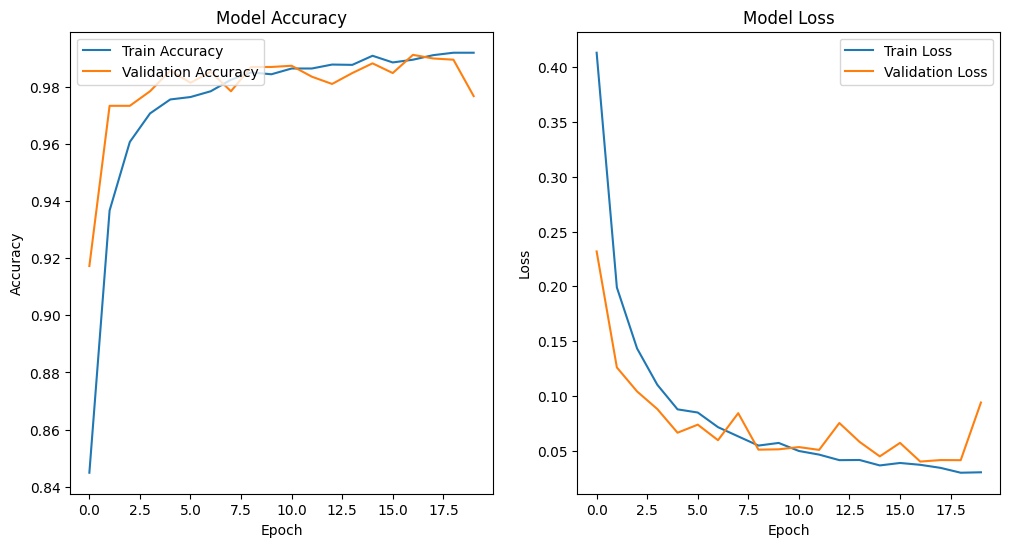

In [26]:

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()
